In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pylab as plt
import copy

import sys
sys.path.append("..")

from fdfdpy import Simulation
from structures import three_port, two_port, ortho_port
from optimization import Optimization

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
lambda0 = 2e-6              # free space wavelength (m)
c0 = 3e8                    # speed of light in vacuum (m/s)
omega = 2*np.pi*c0/lambda0  # angular frequency (2pi/s)
dl = 1.6e-1                 # grid size (L0)
NPML = [15, 15]             # number of pml grid points on x and y borders
pol = 'Ez'                  # polarization (either 'Hz' or 'Ez')
source_amp = 1             # amplitude of modal source (A/L0^2?)

In [3]:
# material constants
n_index = 2.44              # refractive index
eps_m = n_index**2          # relative permittivity
chi3 = 4.1*1e-19            # Al2S3 from Boyd (m^2/V^2)
max_ind_shift = 5.8e-3      # maximum allowed nonlinear refractive index shift (computed from damage threshold)

In [4]:
# geometric parameters
L1 = 5         # length waveguides in design region (L0)
L2 = 5          # width of box (L0)
H = 5          # height waveguides in design region (L0)
H2 = 5          # height of box (L0)
w = .2          # width of waveguides (L0)
l = 2           # length of waveguide from PML to box (L0)
spc = 2         # space between box and PML (L0)

Computed a domain with 86 grids in x and 86 grids in y
The simulation has 12 grids per free space wavelength


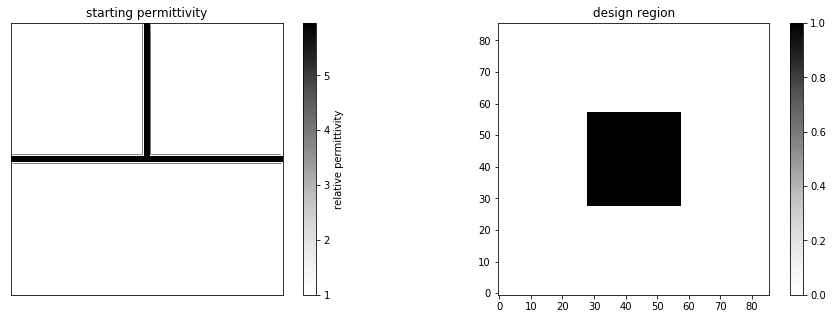

In [5]:
# define permittivity of three port system
eps_r, design_region = ortho_port(L1, L2, H, H2, w, l, dl, NPML, eps_m)
(Nx, Ny) = eps_r.shape
nx, ny = int(Nx/2), int(Ny/2)            # halfway grid points

simulation = Simulation(omega,eps_r,dl,NPML,pol)
# compute the grid size the total grid size
print("Computed a domain with {} grids in x and {} grids in y".format(Nx,Ny))
print("The simulation has {} grids per free space wavelength".format(int(lambda0/dl/simulation.L0)))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
simulation.plt_eps(ax=ax1)
ax1.set_title('starting permittivity')
a = ax2.imshow(design_region.T, origin='lower', cmap='Greys')
plt.colorbar(a, ax=ax2)
ax2.set_title('design region')
plt.show()

In [6]:
# set the modal source and probes
simulation = Simulation(omega, eps_r, dl, NPML, 'Ez')
simulation.add_mode(np.sqrt(eps_m), 'y', [nx, -NPML[1]-int(l/2/dl)], int(H/2/dl), scale=source_amp)
simulation.setup_modes()

# left modal profile
left = Simulation(omega, eps_r, dl, NPML, 'Ez')
left.add_mode(np.sqrt(eps_m), 'x', [NPML[0]+int(l/2/dl), ny], int(H/2/dl))
left.setup_modes()
J_left = np.abs(left.src)

# right modal profile
right = Simulation(omega, eps_r, dl, NPML, 'Ez')
right.add_mode(np.sqrt(eps_m), 'x', [-NPML[0]-int(l/2/dl), ny], int(H/2/dl))
right.setup_modes()
J_right = np.abs(right.src)

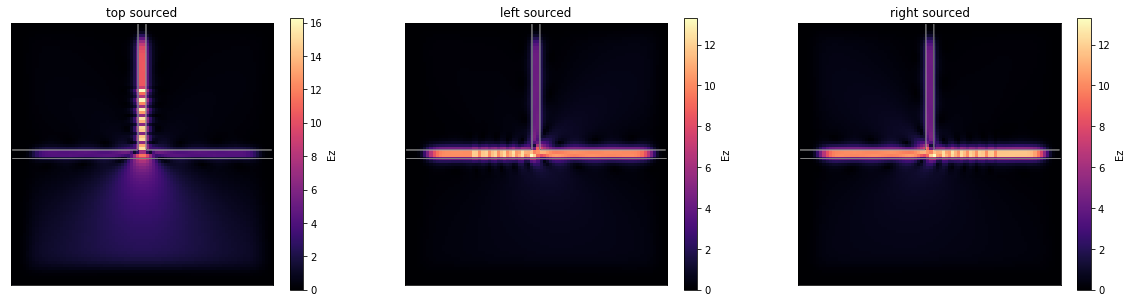

In [7]:
# set source and solve for electromagnetic fields
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))

_ = simulation.solve_fields()
_ = left.solve_fields()
_ = right.solve_fields()

simulation.plt_abs(outline=True, cbar=True, ax=ax1)
left.plt_abs(outline=True, cbar=True, ax=ax2)
right.plt_abs(outline=True, cbar=True, ax=ax3)
ax1.set_title('top sourced')
ax2.set_title('left sourced')
ax3.set_title('right sourced')
plt.show()

computed a scale of 176.87967418746933 in units of E^2 J_out


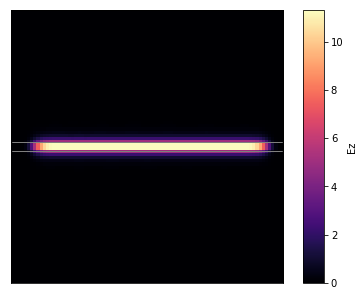

In [8]:
# compute straight line simulation
eps_r_wg, _ = two_port(L1, H, w, l, spc, dl, NPML, eps_start=eps_m)
(Nx_wg, Ny_wg) = eps_r_wg.shape
nx_wg, ny_wg = int(Nx_wg/2), int(Ny_wg/2)            # halfway grid points     
simulation_wg = Simulation(omega, eps_r_wg, dl, NPML, 'Ez')
simulation_wg.add_mode(np.sqrt(eps_m), 'x', [NPML[0]+int(l/2/dl), ny_wg], int(H/2/dl), scale=source_amp)
simulation_wg.setup_modes()

# compute normalization
sim_out = Simulation(omega, eps_r_wg, dl, NPML, 'Ez')
sim_out.add_mode(np.sqrt(eps_m), 'x', [-NPML[0]-int(l/2/dl), ny], int(H/2/dl))
sim_out.setup_modes()
J_out = np.abs(sim_out.src)
(_, _, Ez_wg) = simulation_wg.solve_fields()
SCALE = np.sum(np.square(np.abs(Ez_wg))*J_out)
simulation_wg.plt_abs()
W_in = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny], int(H/2))
print('computed a scale of {} in units of E^2 J_out'.format(SCALE))

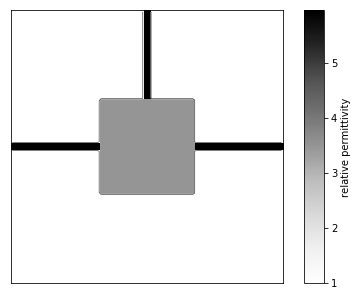

In [9]:
# set the design region to whatever you want in {'full','halfway','empty','random'}. 
# if not in this list, then uses current eps of simulation by default
simulation.init_design_region(design_region, eps_m, style='halfway')
simulation.plt_eps()
plt.show()

In [10]:
# add nonlinearity
nl_region = copy.deepcopy(design_region)

simulation.nonlinearity = []  # This is needed in case you re-run this cell, for example (or you can re-initialize simulation every time)
simulation.add_nl(chi3, nl_region, eps_scale=True, eps_max=eps_m)

In [11]:
# define objective function
import autograd.numpy as npa
def J(e, e_nl, eps):
    """ objective function of BOOST means perfect separation between linear and nonlinear
        note: need BOOST if the objective function is too low (source amplitude is low).
        In this case LBFGS just converges and returns before it's actually done.
        Working on this.
        MAKE SURE YOU USE npa. instead of np.   !!!
    """
    BOOST = 1e0
    linear_right =     1*npa.sum(npa.square(npa.abs(e))*J_right)
    linear_left =     -1*npa.sum(npa.square(npa.abs(e))*J_left)
    nonlinear_right = -1*npa.sum(npa.square(npa.abs(e_nl))*J_right)
    nonlinear_left =   1*npa.sum(npa.square(npa.abs(e_nl))*J_left)
    objfn = (linear_right + linear_left + nonlinear_right + nonlinear_left)/2
    return objfn / SCALE * BOOST

In [12]:
# make optimization object and check derivatives
optimization = Optimization(J=J, Nsteps=250, eps_max=eps_m, field_start='linear', nl_solver='newton', max_ind_shift=None)

# check the derivatives (note, full derivatives are checked, linear and nonlinear no longer separate)
(grad_avm, grad_num) = optimization.check_deriv(simulation, design_region, Npts=4)
print('adjoint gradient   = {}\nnumerical gradient = {}'.format(grad_avm, grad_num))

adjoint gradient   = [2.0429680178991882e-07, 1.501335628224538e-08, -4.495493277547474e-08, -1.855178027508847e-08]
numerical gradient = [2.0429824947297642e-07, 1.501305490937202e-08, -4.498607879672247e-08, -1.8547155889604155e-08]


In [13]:
optimization.J = J
optimization.Nsteps=1000
optimization.run(simulation, design_region, method='lbfgs', step_size=1e-2, beta1=0.9, beta2=.999)

 ObjectiveFn:  0.617 Iteration:  181/1000 ETA:   0:15:25                       

the simulation did not converge, reached 0.26751001022675347
the simulation did not converge, reached 0.16743725441018228


 ObjectiveFn:   0.63 Iteration:  186/1000 ETA:   0:14:17                       

the simulation did not converge, reached 0.19923466167278447


 ObjectiveFn:  0.707 Iteration:  224/1000 ETA:   0:17:26                       

the simulation did not converge, reached 0.11325537440756378


 ObjectiveFn:  0.712 Iteration:  227/1000 ETA:   0:17:27                       

the simulation did not converge, reached 0.13338052514261425


 ObjectiveFn:  0.717 Iteration:  230/1000 ETA:   0:15:22                       

the simulation did not converge, reached 0.20309475067673335
the simulation did not converge, reached 0.3345613883427062
the simulation did not converge, reached 0.17038185141043477
the simulation did not converge, reached 0.4190315991653298
the simulation did not converge, reached 0.3455698917349225


 ObjectiveFn:   0.72 Iteration:  234/1000 ETA:   0:48:59                       

the simulation did not converge, reached 0.0013696037524523138


 ObjectiveFn:  0.724 Iteration:  238/1000 ETA:   0:16:47                       

the simulation did not converge, reached 0.07027902072356688


 ObjectiveFn:   0.77 Iteration:  301/1000 ETA:   0:25:56                       

the simulation did not converge, reached 0.47705029449297615


 ObjectiveFn:  0.791 Iteration:  396/1000 ETA:   0:26:42                       

the simulation did not converge, reached 0.1779147290510657


 ObjectiveFn:  0.796 Iteration:  445/1000 ETA:   0:16:30                       

the simulation did not converge, reached 0.09730553115201517


 ObjectiveFn:  0.799 Iteration:  487/1000 ETA:   0:09:35                       

the simulation did not converge, reached 0.08711580403089403


 ObjectiveFn:  0.801 Iteration:  505/1000 ETA:   0:10:10                       

the simulation did not converge, reached 0.26885356449344566


 ObjectiveFn:  0.802 Iteration:  516/1000 ETA:   0:11:52                       

the simulation did not converge, reached 0.49985599707997874


 ObjectiveFn:  0.803 Iteration:  519/1000 ETA:   0:24:53                       

KeyboardInterrupt: 

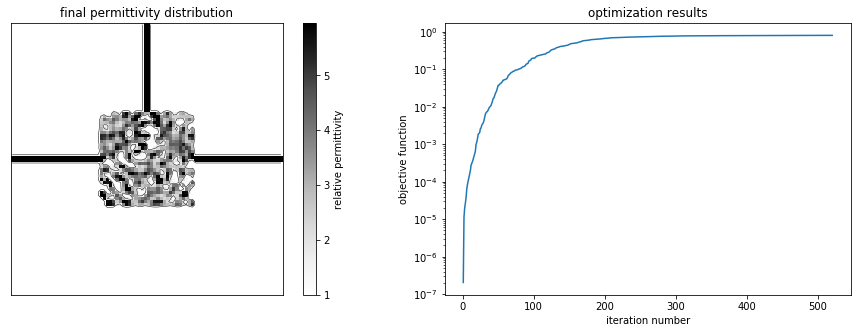

In [15]:
# plot optimization results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

simulation.plt_eps(ax=ax1)
ax1.set_title('final permittivity distribution')

optimization.plt_objs(ax=ax2, norm='po1wer')
ax2.set_yscale('log')
plt.show()

In [21]:
from utils import Binarizer
binarizer = Binarizer(design_region, eps_m)
J_bin = binarizer.density(J)
optimization.J = J_bin
optimization.Nsteps = 1000
new_eps = optimization.run(simulation, design_region, method='lbfgs')

 ObjectiveFn: ------ Iteration:  0/1000 ETA:  --:--:--                         

the simulation did not converge, reached 0.037964268070487875


 ObjectiveFn:  0.242 Iteration:  1/1000 ETA:   2:01:33                         

the simulation did not converge, reached 0.37684935652927537


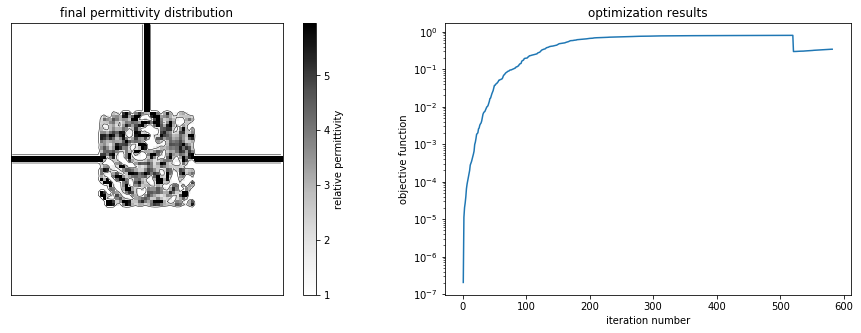

In [17]:
# plot optimization results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

simulation.plt_eps(ax=ax1)
ax1.set_title('final permittivity distribution')

optimization.plt_objs(ax=ax2, norm='po1wer')
ax2.set_yscale('log')
plt.show()

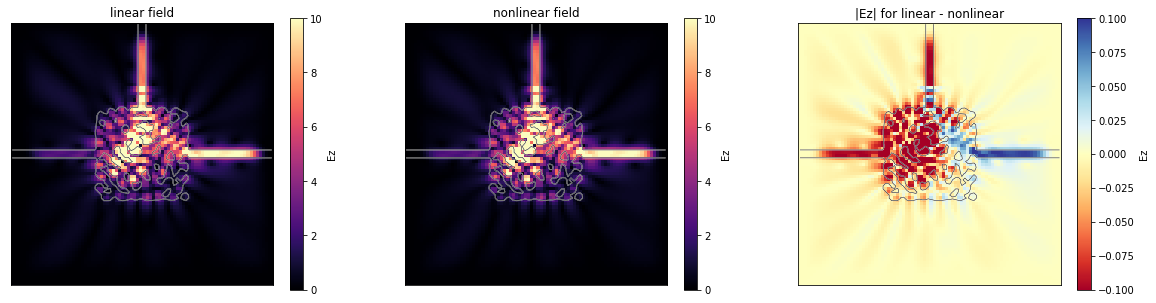

In [20]:
# compare the linear and nonlinear fields

# setup subplots
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))

# linear fields
(Hx,Hy,Ez) = simulation.solve_fields()
simulation.plt_abs(ax=ax1, vmax=10)
ax1.set_title('linear field')

# nonlinear fields
(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl()
simulation.plt_abs(ax=ax2, vmax=10)
ax2.set_title('nonlinear field')

# difference
simulation.plt_diff(ax=ax3, vmax=0.1)
ax3.set_title('|Ez| for linear - nonlinear')

plt.show()

maximum refractive index shift of 0.008469079306319127


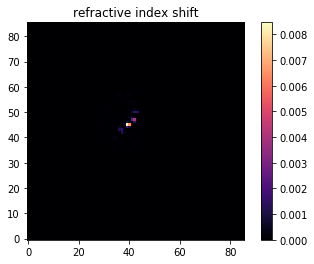

In [14]:
# compute the refractive index shift
index_shift = simulation.compute_index_shift()
print('maximum refractive index shift of {}'.format(np.max(index_shift)))
plt.imshow(index_shift.T, cmap='magma', origin='lower')
plt.colorbar()
plt.title('refractive index shift')
plt.show()

In [ ]:
# input power
print("W_in = {}".format(W_in))

# linear powers
(Hx,Hy,Ez) = simulation.solve_fields()
W_right_lin =  simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny], int(H/2))
W_left_lin  = -simulation.flux_probe('x', [ NPML[0]+int(l/2/dl), ny], int(H/2))

# nonlinear powers
(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl()
W_right_nl =  simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny], int(H/2))
W_left_nl  = -simulation.flux_probe('x', [ NPML[0]+int(l/2/dl), ny], int(H/2))


print('linear transmission (right)              = {:.4f}'.format(W_right_lin / W_in))
print('linear transmission (left)               = {:.4f}'.format(W_left_lin / W_in))
print('nonlinear transmission (right)           = {:.4f}'.format(W_right_nl / W_in))
print('nonlinear transmission (left)            = {:.4f}'.format(W_left_nl / W_in))
# print('relative power difference (right)        = {:.2f} %'.format(100*abs(W_right_lin - W_right_nl) / W_in))
# print('relative power difference (left)         = {:.2f} %'.format(100*abs(W_left_lin  - W_left_nl)  / W_in))

S = [[W_left_lin / W_in, W_right_lin / W_in],
     [W_left_nl / W_in,  W_right_nl / W_in]]
plt.imshow(S, cmap='magma')
plt.colorbar()
plt.title('power matrix')
plt.show()

In [ ]:
freqs, objs, FWHM = optimization.scan_frequency(Nf=20, df=1/400)
optimization.simulation.omega = omega
plt.plot([(f-150e12)/1e9 for f in freqs], objs)
plt.xlabel('frequency difference (GHz)')
plt.ylabel('objective function')
plt.show()
print('computed FWHM of {} (GHz):'.format(FWHM/1e9))
print('Q factor of {0:.2E}'.format(omega/2/np.pi/FWHM))